In [1]:
#!/usr/bin/python
import nltk
import numpy as np
import re
import tensorflow as tf
from nltk.tokenize import WordPunctTokenizer
from random import randint

Importing Glove and  40000 words list 

In [2]:
wordsList = np.load('wordsList.npy')
print('Loaded the word list!')
wordsList = wordsList.tolist() #Originally loaded as numpy array
wordsList = [word.decode('UTF-8') for word in wordsList] #Encode words as UTF-8
wordVectors = np.load('wordVectors.npy')
print ('Loaded the word vectors!')
print(len(wordsList))
print(wordVectors.shape)
print(wordsList[5066])
print(wordVectors[5066][:])

Loaded the word list!
Loaded the word vectors!
400000
(400000, 50)
closure
[ 0.50653   0.12284  -0.11653  -0.21052  -1.0672   -0.17536   0.16253
  0.76781   0.25517  -0.15995   0.025424 -0.65425  -0.44638  -0.19395
  0.45319   1.0955    0.050096 -0.36712   0.1729    0.28393   0.85448
 -0.54932  -1.1816    0.066158 -0.58561  -0.84893   0.1947    0.37832
  0.94141   0.62982   2.3869   -0.41035  -0.11599   0.049907 -0.41563
 -0.056999  1.5044   -0.93772  -0.16045   0.80019  -0.44448  -0.50036
  0.065875  0.27778  -0.27505  -0.012317 -0.37458   0.49171  -0.35498
  0.035347]


Extract data from Affective Text a News Headlines from Google News or CNN

In [65]:
#--------------------Extracting Id && sentences from corpus
def extract(dataset):
    f = open(dataset, 'r+')
    linea = f.readline()
    _id = []
    sentences = []
    
    while linea != "":    
        #print(linea.split("#"))
        linea = linea.split("#")
        _id.append(linea[0])
        sentences.append(linea[1])
        linea = f.readline()
    f.close()
    return sentences,_id

dataset = "Affective_Text/affectivetext_trial.xml"
sentences,_id = extract(dataset)
print(_id[0]," ",sentences[0])

1   Mortar assault leaves at least 18 dead



Extracting Emotion from Affective Text dataset : {happiness, sadness, anger, disgust, surprise, and fear}

In [66]:
#--------------------Extracting the most high emotion 
def extract_emo(dataset):
    f = open(dataset, 'r+')
    linea = f.readline()
    emotions = []
    while linea != "":    
        linea = linea.split(" ")
        linea.pop(0)
        _max = linea.index(max(linea))
        emotions.append(_max)
        linea = f.readline()
    f.close()
    return emotions

dataset = "Affective_Text/affectivetext_trial.emotions.gold"
emotions = extract_emo(dataset)
print(emotions)

[4, 3, 3, 2, 5, 3, 3, 5, 3, 3, 3, 4, 3, 5, 4, 0, 3, 4, 3, 4, 3, 2, 3, 5, 0, 3, 1, 2, 5, 2, 1, 3, 3, 0, 3, 2, 0, 4, 2, 5, 4, 4, 5, 4, 4, 2, 4, 5, 2, 2, 2, 1, 0, 3, 3, 4, 5, 5, 0, 1, 2, 4, 2, 5, 3, 5, 2, 2, 4, 3, 5, 2, 0, 0, 0, 3, 1, 4, 3, 5, 1, 2, 3, 3, 3, 5, 5, 2, 0, 3, 3, 4, 3, 4, 3, 0, 2, 0, 2, 2, 0, 1, 1, 3, 3, 4, 3, 3, 3, 4, 5, 4, 1, 2, 0, 4, 0, 3, 3, 0, 5, 3, 0, 2, 0, 0, 1, 2, 3, 3, 1, 2, 5, 4, 2, 0, 0, 0, 5, 3, 3, 2, 0, 1, 3, 4, 2, 3, 5, 5, 5, 3, 3, 2, 4, 4, 4, 0, 2, 5, 5, 0, 2, 2, 2, 5, 2, 3, 3, 4, 1, 3, 3, 5, 4, 4, 3, 3, 2, 2, 5, 5, 5, 5, 1, 5, 3, 4, 3, 0, 0, 5, 0, 4, 0, 2, 4, 2, 3, 1, 3, 4, 4, 5, 4, 4, 0, 3, 2, 1, 0, 4, 4, 1, 0, 5, 0, 2, 5, 3, 5, 3, 5, 5, 3, 0, 3, 0, 2, 5, 3, 4, 3, 3, 3, 5, 3, 3, 0, 5, 3, 5, 4, 4, 5, 4, 3, 3, 2, 1]


Preprocesing of Sentences

In [67]:
def decontracted(phrase):
    # specific
    '''phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)'''

    if phrase == "t":
        phrase = "not"
    elif phrase == "re":
        phrase = "are"
    elif phrase == "s":
        phrase = "is"
    elif phrase == "d":
        phrase = "would"
    elif phrase == "ve":
        phrase = "have"
    elif phrase == "m":
        phrase = "am"
    elif phrase == "ca":
        phrase = "can"
    elif phrase == "isn":
        phrase = "is"
    elif phrase == "aren":
        phrase = "are"
    elif phrase == "wouldn":
        phrase = "would"

    # general
    '''phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)'''
    return phrase

In [68]:
#----------------Cleanning Sentences--------------
def cleaner(sent):
    for s in range(0,len(sent)):
        print(sent[s])
        sent[s] = sent[s].lower()
        sent[s] = WordPunctTokenizer().tokenize(sent[s])#nltk.word_tokenize(sent[s])
        #print(sent[s])
        for word in range(0,len(sent[s])):
            sent[s][word] = decontracted(sent[s][word])
            sent[s][word] = re.sub(r'[^a-zA-Z0-9\s]', ' ', sent[s][word])
            sent[s][word] = sent[s][word].strip()
            
        sent[s] = list(filter(None, sent[s])) # fastest
        print(sent[s])
        print("-----------")
    return sent

c_sent = sentences[:]    
c_sent = cleaner(c_sent)
print(c_sent[0])

Mortar assault leaves at least 18 dead

['mortar', 'assault', 'leaves', 'at', 'least', '18', 'dead']
-----------
Goal delight for Sheva

['goal', 'delight', 'for', 'sheva']
-----------
Nigeria hostage feared dead is freed

['nigeria', 'hostage', 'feared', 'dead', 'is', 'freed']
-----------
Bombers kill shoppers

['bombers', 'kill', 'shoppers']
-----------
Vegetables, not fruit, slow brain decline

['vegetables', 'not', 'fruit', 'slow', 'brain', 'decline']
-----------
PM: Havana deal a good experiment

['pm', 'havana', 'deal', 'a', 'good', 'experiment']
-----------
Kate is marrying Doherty

['kate', 'is', 'marrying', 'doherty']
-----------
NASA revisiting life on Mars question

['nasa', 'revisiting', 'life', 'on', 'mars', 'question']
-----------
Happy birthday, iPod

['happy', 'birthday', 'ipod']
-----------
Alonso would be happy to retire with three titles

['alonso', 'would', 'be', 'happy', 'to', 'retire', 'with', 'three', 'titles']
-----------
Madonna's New Tot 'Happy at Home' in Lon

Les't determine the total and average number of words in each sentences

In [69]:
def maximum(sent):
    numWords = []
    for s in sent:
        counter = len(s)
        numWords.append(counter) 
    maxLengh = int(sum(numWords)/len(numWords))
    print("Average: ", maxLengh)
    return numWords,maxLengh
numWords,maxSeqLength = maximum(c_sent)

Average:  6


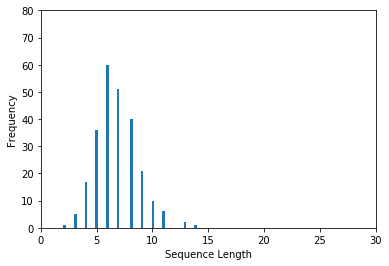

In [70]:
import matplotlib.pyplot as plt
%matplotlib inline
def histograma(numWords):
    plt.hist(numWords, 50)
    plt.xlabel('Sequence Length')
    plt.ylabel('Frequency')
    plt.axis([0, 30, 0, 80])
    plt.show()
histograma(numWords)

Converting each sentence into a vector and adding it into a matrix of 'ids'

In [71]:
def integerSenteces(sent,maximum):
    i = 0
    embbeding = 0
    matrix = np.zeros((len(sent), maximum)) #250 X 6 (numEjem X Maximun)
    for s in sent:
        vector = np.zeros((maximum), dtype='int32')
        bound = maximum
        if len(s) < maximum:
            bound = len(s)    

        for token in range(0,bound): #No encuentra macu, porque la corta
            if s[token] not in wordsList:
                vector[token] = embbeding # ???
                print(s[token],"*---*",sent[i])
            else:
                vector[token] = (wordsList.index(s[token]))
                embbeding = vector[token]
        matrix[i] = (vector)
        i += 1
    return matrix

In [72]:
X_train = integerSenteces(c_sent,maxSeqLength) 
print("Sentences integer representation: ",(X_train.shape))
print("Sentences: ",len(c_sent))
print("Integer format",X_train[249])
print("Normal format",c_sent[249])

Sentences integer representation:  (250, 6)
Sentences:  250
Integer format [  38.   32.   81. 1525. 3747.    0.]
Normal format ['who', 'are', 'you', 'calling', 'fat']


Writting the labels : Y train Labels

In [73]:
def toLabels(emo):
    Y = np.zeros((len(emo), 5))
    for e in range(0,len(emo)):
        vector = np.zeros((5))
        vector[(emo[e] % 6) - 1] = 1 
        Y[e] = vector
    return Y
 
Y_train = toLabels(emotions)
print("Y_train: ",Y_train.shape," Num Ejem X 5 clases")
print("X_train: ",X_train.shape," Num Ejem X Maximun Lengh")

Y_train:  (250, 5)  Num Ejem X 5 clases
X_train:  (250, 6)  Num Ejem X Maximun Lengh


RNN Model

In [74]:
batchSize = 50 #Tiene que ser multiplo del NumEjem
lstmUnits = 64
numClasses = 5

Declarando placeholders para los labels (5 emotions) && data imput

In [103]:
import tensorflow as tf
tf.reset_default_graph()
numDimensions = 300 

#labels = tf.placeholder(tf.float32, [batchSize, numClasses])
#input_data = tf.placeholder(tf.int32, [batchSize, maxSeqLength])
labels = tf.placeholder(tf.float32, [None, numClasses])
input_data = tf.placeholder(tf.int32, [None, maxSeqLength])

Embeddings: Le damos el formato a nuestra data, aún no compilamos nada, solo declaramos

In [104]:
data = tf.Variable(tf.zeros([batchSize, maxSeqLength, numDimensions]),dtype=tf.float32)
data = tf.nn.embedding_lookup(wordVectors,input_data)

LSTM Model

In [105]:
lstmCell = tf.contrib.rnn.BasicLSTMCell(lstmUnits)
lstmCell = tf.contrib.rnn.DropoutWrapper(cell=lstmCell, output_keep_prob=0.75)
value, _ = tf.nn.dynamic_rnn(lstmCell, data, dtype=tf.float32)

In [106]:
weight = tf.Variable(tf.truncated_normal([lstmUnits, numClasses]))
bias = tf.Variable(tf.constant(0.1, shape=[numClasses]))
value = tf.transpose(value, [1, 0, 2])
last = tf.gather(value, int(value.get_shape()[0]) - 1)
prediction = (tf.matmul(last, weight) + bias)

In [107]:
correctPred = tf.equal(tf.argmax(prediction,1), tf.argmax(labels,1))
accuracy = tf.reduce_mean(tf.cast(correctPred, tf.float32))

In [108]:
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=prediction, labels=labels))
optimizer = tf.train.AdamOptimizer().minimize(loss)

/home/danielafe7/.conda/envs/NLTK/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Tensorboar

In [109]:
import datetime
def board(sess):
    tf.summary.scalar('Loss', loss)
    tf.summary.scalar('Accuracy', accuracy)
    tf.summary.histogram("Histogrma/hAccu", accuracy)
    merged = tf.summary.merge_all()
    logdir = "board/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "/"
    writer = tf.summary.FileWriter(logdir, sess.graph)
    return merged,writer

Preparing Test Data

500   Test to predict breast cancer relapse is approved

[4, 5, 5, 3, 5, 0, 5, 2, 4, 4, 5, 5, 1, 5, 0, 3, 5, 0, 4, 5, 0, 4, 1, 1, 5, 5, 3, 5, 1, 5, 4, 1, 5, 2, 3, 5, 4, 4, 3, 1, 3, 3, 4, 4, 2, 3, 0, 4, 5, 0, 0, 1, 3, 2, 4, 5, 3, 5, 2, 3, 2, 1, 1, 2, 3, 4, 3, 3, 5, 2, 0, 5, 0, 5, 2, 3, 1, 0, 2, 0, 3, 0, 2, 2, 2, 4, 3, 5, 3, 4, 2, 2, 3, 3, 5, 2, 5, 5, 2, 5, 5, 2, 5, 2, 4, 4, 5, 3, 4, 2, 5, 5, 5, 3, 3, 0, 0, 0, 3, 3, 1, 2, 2, 2, 2, 5, 5, 3, 3, 4, 2, 3, 2, 5, 2, 3, 5, 1, 5, 5, 1, 3, 3, 0, 1, 1, 0, 3, 2, 3, 5, 5, 4, 0, 3, 1, 2, 2, 2, 5, 3, 5, 5, 5, 4, 2, 3, 2, 4, 5, 5, 2, 2, 5, 4, 3, 1, 2, 4, 2, 3, 2, 3, 5, 5, 3, 1, 0, 5, 0, 4, 4, 0, 4, 3, 2, 4, 5, 1, 5, 5, 0, 3, 5, 5, 2, 2, 5, 5, 4, 4, 5, 4, 4, 3, 3, 0, 0, 5, 3, 3, 3, 3, 2, 4, 5, 4, 5, 5, 3, 3, 3, 0, 4, 2, 3, 2, 3, 0, 5, 4, 5, 4, 2, 3, 5, 3, 2, 4, 5, 3, 3, 1, 4, 4, 1, 5, 1, 5, 3, 3, 0, 0, 5, 5, 3, 4, 4, 3, 3, 0, 2, 3, 5, 4, 5, 4, 3, 5, 2, 3, 1, 5, 3, 2, 2, 2, 5, 0, 1, 2, 0, 2, 0, 5, 0, 4, 5, 1, 5, 3, 0, 0, 3, 5, 5, 4, 5, 3, 4, 3, 4, 5, 5, 

UN-Google Earth map climate change

['un', 'google', 'earth', 'map', 'climate', 'change']
-----------
['test', 'to', 'predict', 'breast', 'cancer', 'relapse', 'is', 'approved']
Average:  6


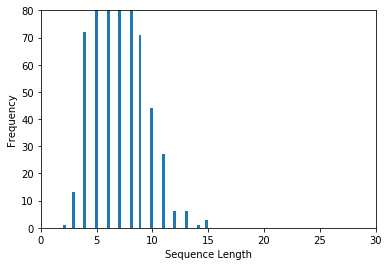

schuey *---* ['schuey', 'sees', 'ferrari', 'unveil', 'new', 'car']
bananaconda *---* ['bananaconda', 'inventor', 'is', 'top', 'poet', 'of', 'kids']
upgraders *---* ['apple', 'to', 'vista', 'upgraders', 'wait']
blissing *---* ['blissing', 'out', 'in', 'ojai']
65bn *---* ['google', 'buys', 'youtube', 'for', '1', '65bn']
pantful *---* ['scorpion', 'on', 'a', 'plane', 'a', 'pantful', 'of', 'pain']
edns *---* ['mideast', 'summit', 'edns', 'with', 'little', 'progress']
hitfactory *---* ['reopening', 'bird', 'flu', 'hitfactory', 'ignores', 'risks', 'poultryman']
revells *---* ['bruce', 'revells', 'in', 'upset']
thrillville *---* ['create', 'own', 'thrillville', 'for', 'a', 'wild', 'ride']
portege *---* ['toshiba', 'portege', 'r400']
Sentences integer representation:  (1000, 6)
Sentences:  1000
Integer format [7.2800e+02 4.0000e+00 6.3260e+03 5.3530e+03 1.6470e+03 3.0492e+04]
Normal format ['test', 'to', 'predict', 'breast', 'cancer', 'relapse', 'is', 'approved']
Y_train:  (1000, 5)  Num Ejem 

In [110]:
#Separamos Sentences && ids
dataset = "Affective_Text/affectivetext_test.xml"
sent_test , id_test = extract(dataset)
print(id_test[0]," ",sent_test[0])

#Escogemos the most hight emotion
dataset = "Affective_Text/affectivetext_test.emotions.gold"
test_emotions = extract_emo(dataset)
print(test_emotions)

#Limpiamos las Sentences
c_sent_test = sent_test[:]    
c_sent_test = cleaner(c_sent_test)
print(c_sent_test[0])

#Calculamos la oracion promedio
test_numWords,test_maxSeqLength = maximum(c_sent_test)
histograma(test_numWords)

#Convertimos Sentences a su representacion en Integers
X_test = integerSenteces(c_sent_test,test_maxSeqLength) 
print("Sentences integer representation: ",(X_test.shape))
print("Sentences: ",len(c_sent_test))
print("Integer format",X_test[0])
print("Normal format",c_sent_test[0])

#Transformamos cada emocion {1,2,3,4,5} a one-hot vectors
Y_test = toLabels(test_emotions)
print("Y_train: ",Y_test.shape," Num Ejem X 5 clases")
print("X_train: ",X_test.shape," Num Ejem X Maximun Lengh")

In [114]:
# Initializing the variables
init = tf.global_variables_initializer()
display_step = 10
numEjemplos = 250
iterations = 100

In [119]:
# Launch the graph
with tf.Session() as sess:
    sess.run(init)
    #Calling tensorboard function
    #---merged,writer = board(sess)
    
    # Training cycle
    for epoch in range(iterations):
        avg_cost = 0.
        total_batch = int(numEjemplos/batchSize)
        
        #Create X groups of (50,5) Labels && (50,maximum) Examples
        X_batches = np.array_split(X_train, total_batch)
        Y_batches = np.array_split(Y_train, total_batch)
        # Loop over all batches
        for i in range(total_batch):
            batch_x, batch_y = X_batches[i], Y_batches[i]
            #print("X: ",batch_x.shape)
            #print("Y: ",batch_y.shape)
            # Run optimization op (backprop) and cost op (to get loss value)
            _, c , accu= sess.run([optimizer, loss, accuracy], feed_dict={input_data: batch_x,
                                                          labels: batch_y})
            # Compute average loss
            avg_cost += c / total_batch

            #Write summary to Tensorboard
            '''if (epoch % 10 == 0):
                summary = sess.run(merged, {input_data: batch_x, labels: batch_y})
                writer.add_summary(summary, epoch)'''
            

            #Save the network every 10,000 training iterations
            #if (i % 10000 == 0 and i != 0):
                # save_path = saver.save(sess, "models/pretrained_lstm.ckpt", global_step=i)
                 # print("saved to %s" % save_path)
            #writer.close()

        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(avg_cost)," accuracy=", "{:.9f}".format(accu*100))
    print("Optimization Finished!")
    
    #Test Model LSTM  
    #correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
    correctPred = tf.equal(tf.argmax(prediction,1), tf.argmax(labels,1))

    # Calculate accuracy
    accuracy = tf.reduce_mean(tf.cast(correctPred, "float"))
    print("Accuracy:", accuracy.eval({input_data: X_test, labels: Y_test}))
    
    #Matriz de confusion
    global result 
    result = tf.argmax(prediction , 1).eval({input_data: X_test, labels: Y_test})
    #Predicionedo Test BBVA
    #BBVA = tf.argmax(pred*(-1), 1).eval({x: test_final})
    #print("BBVA: ",BBVA.shape)
    #for i in result:
        #print(i)
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import precision_score
    from sklearn.metrics import f1_score
    from sklearn.metrics import recall_score
    #print(confusion_matrix(Y_test1, result))
    
    print("Precision: ",precision_score(Y_test, result, average='binary'))
    print("Recall: ",recall_score(Y_test, result, average='binary'))
    print("F1: ",f1_score(Y_test, result, average='binary'))

    #Test Model X MiniBacths and Average Accuracy
    '''total_batch = int(1000/batchSize) # 20 batchs of 50 examples
    X_batches = np.array_split(X_test, total_batch)
    Y_batches = np.array_split(Y_test, total_batch)
    avr_accu = 0
    for i in range(total_batch):    
        batch_x, batch_y = X_batches[i], Y_batches[i]
        _accuracy =  (sess.run(accuracy, {input_data: batch_x, labels: batch_y}))
        avr_accu += _accuracy * 100
        print("Accuracy for this batch:", _accuracy * 100)
    print("********************")
    print("Average Accuracy is: ",avr_accu/total_batch)'''
    
    #Test Model 1 Solo Batch
    '''X_batches = X_test
    Y_batches = Y_test
    _accuracy =  (sess.run(accuracy, {input_data: X_batches, labels: Y_batches}))
    print("Accuracy for this batch:", _accuracy * 100)
    '''
    

Epoch: 0001 cost= 1.843177438  accuracy= 25.999999046
Epoch: 0011 cost= 0.990678060  accuracy= 66.000002623
Epoch: 0021 cost= 0.647304869  accuracy= 77.999997139
Epoch: 0031 cost= 0.375622123  accuracy= 92.000001669
Epoch: 0041 cost= 0.188157067  accuracy= 98.000001907
Epoch: 0051 cost= 0.087787078  accuracy= 100.000000000
Epoch: 0061 cost= 0.072031177  accuracy= 100.000000000
Epoch: 0071 cost= 0.049227313  accuracy= 100.000000000
Epoch: 0081 cost= 0.038170765  accuracy= 100.000000000
Epoch: 0091 cost= 0.031812666  accuracy= 100.000000000
Optimization Finished!
Accuracy: 0.3


ModuleNotFoundError: No module named 'sklearn'

In [1]:
from sklearn.metrics import f1_score


ModuleNotFoundError: No module named 'sklearn'